# Varible Energy Positron Annihilation Spectroscopy Doppler Broadning Analysis Example
This notebook contains example on how to use pyPAS in order to allow 
The units of length in this package is micrometers

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from scipy.optimize import minimize, curve_fit, least_squares
from scipy.constants import nano, micro, centi

import matplotlib.pyplot as plt

from pyPAS.positron_implantation_profile import ghosh_material_parameters, ghosh_profile, multilayer_implementation_profile
from pyPAS.positron_annihilation_profile import positrons_annihilation_profile_solver, profile_annihilation_fraction
from pyPAS.sample import Layer, Material, Sample
from pyPAS.vedb import TwoBulkDiffusionLengthOptimization

from pyspectrum import germanium_fwhm

import dask
from dask.diagnostics import ProgressBar

from itertools import product

from uncertainties import nominal_value, std_dev, ufloat
from uncertainties.unumpy import uarray, nominal_values, std_devs

#  positron implementation profile in gosh and makhov methods

In [2]:
data_gos = ghosh_material_parameters()

# diffusion length analysis

## load the s parameter

In [3]:
lineshape_parm_1 = pd.read_csv('./libs/pbs/pbs1_err.csv', names=['energy', 's', 's_error', 'w', 'w_error'], index_col=0)
lineshape_parm_2 = pd.read_csv('./libs/pbs/pbs2_err.csv', names=['energy', 's', 's_error', 'w', 'w_error'], index_col=0)
lineshape_parm_3 = pd.read_csv('./libs/pbs/pbs3_err.csv', names=['energy', 's', 's_error', 'w', 'w_error'], index_col=0)
lineshape_parm_4 = pd.read_csv('./libs/pbs/pbs4_err.csv', names=['energy', 's', 's_error', 'w', 'w_error'], index_col=0)

s_1 = xr.DataArray(uarray(lineshape_parm_1.s,lineshape_parm_1.s_error), coords={'energy':lineshape_parm_1.index})
s_2 = xr.DataArray(uarray(lineshape_parm_2.s,lineshape_parm_2.s_error), coords={'energy':lineshape_parm_2.index})
s_3 = xr.DataArray(uarray(lineshape_parm_3.s,lineshape_parm_3.s_error), coords={'energy':lineshape_parm_3.index})
s_4 = xr.DataArray(uarray(lineshape_parm_4.s,lineshape_parm_4.s_error), coords={'energy':lineshape_parm_4.index})

w_1 = xr.DataArray(uarray(lineshape_parm_1.w,lineshape_parm_1.w_error), coords={'energy':lineshape_parm_1.index})
w_2 = xr.DataArray(uarray(lineshape_parm_2.w,lineshape_parm_2.w_error), coords={'energy':lineshape_parm_2.index})
w_3 = xr.DataArray(uarray(lineshape_parm_3.w,lineshape_parm_3.w_error), coords={'energy':lineshape_parm_3.index})
w_4 = xr.DataArray(uarray(lineshape_parm_4.w,lineshape_parm_4.w_error), coords={'energy':lineshape_parm_4.index})

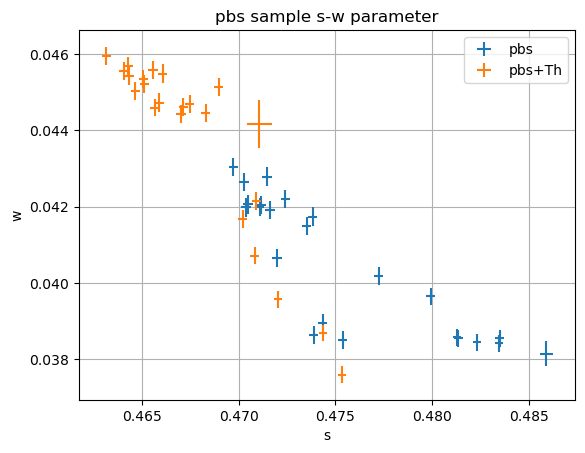

In [4]:
plt.errorbar(x=nominal_values(s_1), y=nominal_values(w_1), yerr=std_devs(w_1), xerr=std_devs(w_1), ls='')
plt.errorbar(x=nominal_values(s_2), y=nominal_values(w_2), yerr=std_devs(w_2), xerr=std_devs(w_2), ls='')
#plt.errorbar(x=nominal_values(s_3), y=nominal_values(w_3), yerr=std_devs(w_3), xerr=std_devs(w_3), ls='')
#plt.errorbar(x=nominal_values(s_4), y=nominal_values(w_4), yerr=std_devs(w_4), xerr=std_devs(w_4), ls='')
plt.legend(['pbs','pbs+Th'])#,'pbs_3','pbs_4', ])
plt.title('pbs sample s-w parameter')
plt.xlabel('s')
plt.ylabel('w')
plt.grid(True)

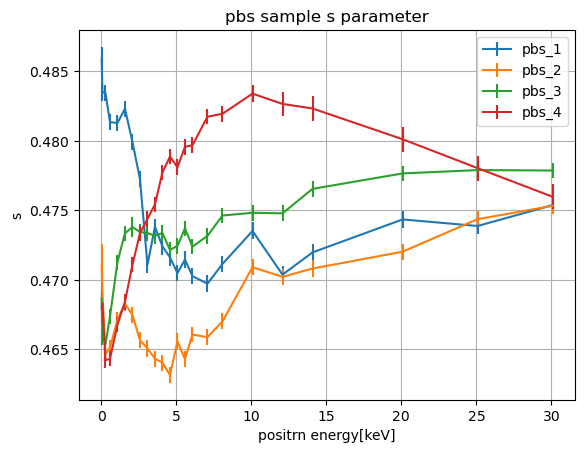

In [5]:
plt.errorbar(x=nominal_values(s_1.energy), y=nominal_values(s_1), yerr=std_devs(s_1), ls='-')
plt.errorbar(x=nominal_values(s_2.energy), y=nominal_values(s_2), yerr=std_devs(s_2), ls='-')
plt.errorbar(x=nominal_values(s_3.energy), y=nominal_values(s_3), yerr=std_devs(s_3), ls='-')
plt.errorbar(x=nominal_values(s_4.energy), y=nominal_values(s_4), yerr=std_devs(s_4), ls='-')
plt.legend(['pbs_1','pbs_2','pbs_3','pbs_4', ])
plt.title('pbs sample s parameter')
plt.xlabel('positrn energy[keV]')
plt.ylabel('s')
plt.grid(True)

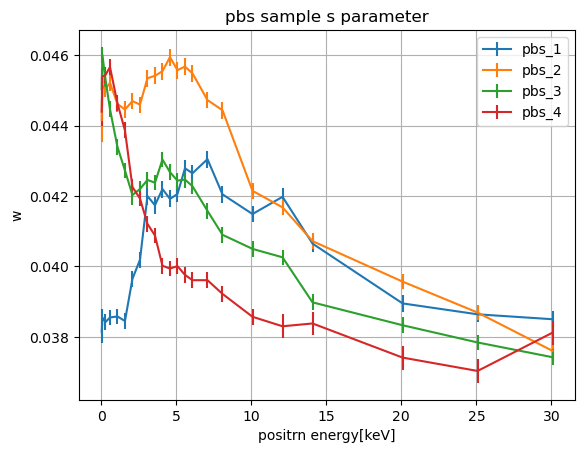

In [6]:
plt.errorbar(x=nominal_values(w_1.energy), y=nominal_values(w_1), yerr=std_devs(w_1), ls='-')
plt.errorbar(x=nominal_values(w_2.energy), y=nominal_values(w_2), yerr=std_devs(w_2), ls='-')
plt.errorbar(x=nominal_values(w_3.energy), y=nominal_values(w_3), yerr=std_devs(w_3), ls='-')
plt.errorbar(x=nominal_values(w_4.energy), y=nominal_values(w_4), yerr=std_devs(w_4), ls='-')
plt.legend(['pbs_1','pbs_2','pbs_3','pbs_4', ])
plt.title('pbs sample s parameter')
plt.xlabel('positrn energy[keV]')
plt.ylabel('w')
plt.grid(True)

In [7]:
PbS = ghosh_material_parameters().iloc[23]
GaAs = ghosh_material_parameters().iloc[22]
PbS_density =7.6


In [8]:
# guess true sample 
L0  = 0.0088#100 * (nano/micro)
L1  = 0.1211799#100 * (nano/micro)

D = 1 * (centi/micro) ** 2 # normal for metals [cm**2/s]
λ_b_0 = D/L0**2 # normal for metals [1/s]
λ_b_1 = D/L1**2 # normal for metals [1/s]

m1 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_0)
m2 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_1)

l0 = Layer(0., 250 * (nano/micro), m1) # infinite sample
l1 = Layer(0., 20, m2) # infinite sample

alpha = D/(100 * (nano/micro)) # assuming around 10 nm

initial_guess_sample = Sample([l0, l1], alpha)

In [9]:
s_param = w_2[1:]

In [10]:
positron_energies = s_param.energy
depth_vector = np.linspace(0, 7, 100000)
widths = [l0.width * (nano/micro), 10]
materials_parameters = [PbS, GaAs]
denseties = [PbS_density, GaAs.density]
positron_implementation_profiles = []
for energy in positron_energies:
    positron_implementation_profiles.append(multilayer_implementation_profile(
        positron_energy=energy.item(),
        depth_vector=depth_vector, 
        widths=widths,
        materials_parameters=materials_parameters,
        densities=denseties,
        implementation_profile_function=ghosh_profile     
    ))
    positron_implementation_profiles[-1] = positron_implementation_profiles[-1]/positron_implementation_profiles[-1].integrate('x')

In [11]:
vedbfit = TwoBulkDiffusionLengthOptimization(positron_implementation_profiles, pd.Series(s_param.values, s_param.energy), initial_guess_sample, num_of_mesh_cells=100000)
parm = vedbfit.optimize_diffusion_length()
parm

{'layer_1': 0.11232610245727591+/-0.04870431997071884,
 'layer_0': 1.9076908716002516+/-771.4286048720502,
 'surface': 0.0025000691625548096+/-32.777443175672}

In [13]:
min_parm = (nominal_value(parm['surface']), nominal_value(parm['layer_0']), nominal_value(parm['layer_1']))

Calculate a grid of likelihood

In [49]:
L_a = np.arange(500, 6000, 500) * (nano/micro)
L_b_0 = np.arange(10, 200, 10) * (nano/micro) #np.arange(10, 500, 10) * (nano/micro)#
L_b_1 = np.arange(10, 200, 10) * (nano/micro)#np.arange(2, 4.5, 0.25) * (nano/micro)

In [50]:
len(L_a)*len(L_b_0)*len(L_b_1)

3971

In [51]:
@dask.delayed
def xhi_sq_test(eff_surface_capture_rate, eff_rate_0, eff_rate_1):
    sample = vedbfit.make_sample(eff_surface_capture_rate, eff_rate_0, eff_rate_1)
    # find s_parm using linear regression
    annihilation_channel_rate_matrix = vedbfit.rate_matrix(sample)
    try:
        s_vec = np.linalg.lstsq(annihilation_channel_rate_matrix, vedbfit.s_measurement, rcond=None)[0]
    except:
        return np.nan
    s_sample = annihilation_channel_rate_matrix @ s_vec
    
    if np.any(s_vec> 0.5) or np.any(s_vec<= 0):
        # if the s value is above 1 make the result None because the likelihood is 0
        return np.nan
    return (((s_sample - vedbfit.s_measurement)/vedbfit.s_measurement_dev)**2).sum()


The lazy list

In [52]:
# Create delayed tasks for the entire grid
lazy_likelihood_list = [
    xhi_sq_test(1 / parm[0], 1 / parm[1]**2, 1 / parm[2]**2)
    for parm in product(L_a, L_b_0, L_b_1)
]

In [53]:
# Compute all the results in parallel
with ProgressBar():
    persisted_likelihoods = dask.persist(*lazy_likelihood_list)

[########################################] | 100% Completed | 100m 42s


In [54]:
likelihood = dask.compute(persisted_likelihoods)

In [55]:
np.array(likelihood).max()

nan

In [56]:
like_max = np.nan_to_num(np.array(likelihood), nan=0).max()
likelihood = xr.DataArray(np.nan_to_num(np.array(likelihood), nan=like_max).reshape((len(L_a), len(L_b_0), len(L_b_1))), coords={'s':L_a, 'l_0':L_b_0, 'l_1':L_b_1})

In [59]:
likelihood_df = likelihood.rename('a').to_dataframe()

In [60]:
min_parm = likelihood_df.idxmin().item()
np.array(min_parm)*1000

array([500., 190.,  50.])

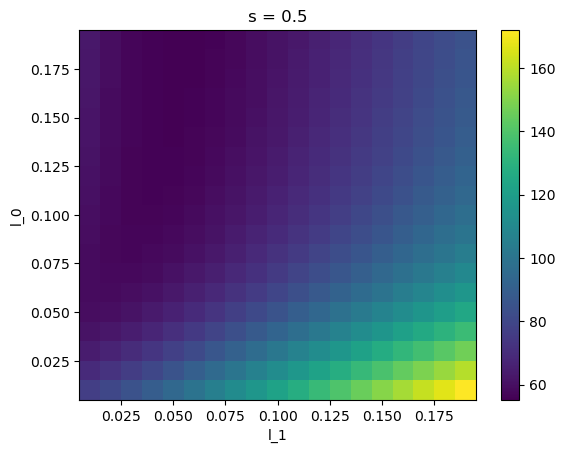

In [61]:
likelihood.sel(s=min_parm[0]).plot()

In [14]:
s_param = s_2[1:]
vedbfit = TwoBulkDiffusionLengthOptimization(positron_implementation_profiles, pd.Series(s_param.values, s_param.energy), initial_guess_sample, num_of_mesh_cells=100000)

tmp_s = vedbfit.s_parameter_calculation(vedbfit.energies, 1 / min_parm[0], 1 / 1 / min_parm[1]**2, 1 / 1 / min_parm[2]**2)

<ErrorbarContainer object of 3 artists>

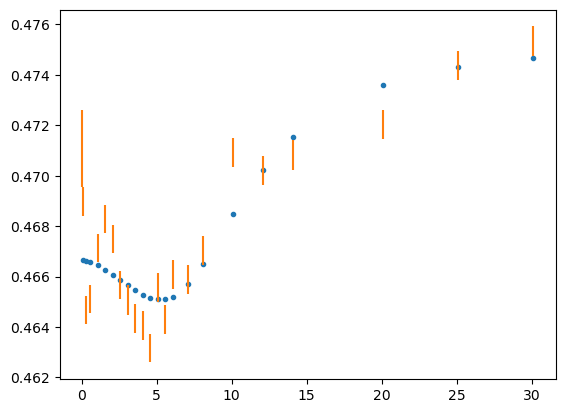

In [15]:
plt.plot(vedbfit.energies, tmp_s, ls='', marker = '.')
#plt.errorbar(x=nominal_values(w_2.energy), y=nominal_values(w_2), yerr=std_devs(w_2), ls='')
plt.errorbar(x=nominal_values(s_2.energy), y=nominal_values(s_2), yerr=std_devs(s_2), ls='')


In [102]:
sample = vedbfit.make_sample( 1 / min_parm[0], 1 / 1 / min_parm[1]**2, 1 / 1 / min_parm[2]**2)
# find s_parm using linear regression
annihilation_channel_rate_matrix = vedbfit.rate_matrix(sample)
s_vec = np.linalg.lstsq(annihilation_channel_rate_matrix, vedbfit.s_measurement, rcond=None)[0]
s_sample = annihilation_channel_rate_matrix @ s_vec


In [103]:
s_vec

array([0.04475121, 0.99981169, 0.03782678])

In [104]:
annihilation_channel_rate_matrix

array([[9.97637461e-01, 3.60760816e-05, 2.32646262e-03],
       [9.96792114e-01, 4.89505441e-05, 3.15893558e-03],
       [9.93285982e-01, 1.02032176e-04, 6.61198545e-03],
       [9.83959362e-01, 2.40759819e-04, 1.57998786e-02],
       [9.70889004e-01, 4.29105471e-04, 2.86818907e-02],
       [9.54477381e-01, 6.55552650e-04, 4.48670661e-02],
       [9.35012423e-01, 9.09603207e-04, 6.40779738e-02],
       [9.12829340e-01, 1.17987301e-03, 8.59907870e-02],
       [8.87810650e-01, 1.46002188e-03, 1.10729328e-01],
       [8.60261395e-01, 1.73818333e-03, 1.38000422e-01],
       [8.30235673e-01, 2.00506225e-03, 1.67759265e-01],
       [7.97886980e-01, 2.25012735e-03, 1.99862892e-01],
       [7.63088461e-01, 2.46445597e-03, 2.34447083e-01],
       [7.26111221e-01, 2.63617324e-03, 2.71252606e-01],
       [6.46101199e-01, 2.81673261e-03, 3.51082069e-01],
       [5.61054065e-01, 2.76694729e-03, 4.36178988e-01],
       [4.03348670e-01, 2.25950975e-03, 5.94391820e-01],
       [2.86299552e-01, 1.68722

In [23]:
from scipy.constants import Avogadro
σ = 0.661*1e-24 # 1.93*1e-24
Σ = 0.175
ρ = 40*Σ/(σ*Avogadro)
ρ

17.585133842990814